# DATA CLUSTERING  
Ein Weg, sich an einen Unbekannten Datensatz anzunähern kann darin bestehen, dass man sich einen Überblick über die vorhandenen Daten verschafft. Im theoretischeren Teil dieser Arbeit wurde versucht einen Eindruck vom Datensatz und den Hürden, die er stellen könnte, durch Stichproben zu erhalten. Hierzu wurden einzelne Scans aus dem Datensatz herausgenommen und auch auf Ihre Details hin untersucht. Diese Methode bietet einen guten Einblick auf die Besonderheiten einzelner Daten, jedoch sind die gewonnen Eindrücke sehr zufällig und können durch eine andere Auswahl an Abbildungen ganz anders aussehen.  
Die Methode des "Data-Clustering" ermöglicht es einen Blick aus der Vogelperspektive auf den Datensatz zu bekommen. Hier geht die Detailbetrachtung des Einzelstücks verloren - gewonnen wird dafür ein besseres Verständnis vom Gesamtkontext des Datensatzes. Das "Data-Clustering" ermöglicht es, große Teile des Datensatzes sofort zu erkennen und möglicherweie Verbindungen zwischen einzelnen Werken zu entdecken, die sonst möglicherwise verborgen geblieben wären.  
Im Folgenden wird nun das Programm beschrieben, dass uns die komplette Sammlung an digitalisierten Plakaten des Kunstmuseums Bayreuth vor uns ausbreitet.  

Dieses Notebook entstand mit Hilfe dieser Webseiten:  
[Image clustering by its similarity in python](https://stackoverflow.com/questions/39123421/image-clustering-by-its-similarity-in-python)  
[How to cluster images based on visual similarity](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34)  
[Using Keras’ Pre-trained Models for Feature Extraction in Image Clustering](https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1)  
[How to Plot K-Means Clusters with Python?](https://www.askpython.com/python/examples/plot-k-means-clusters-python)  
[A demo of K-Means clustering on the handwritten digits data](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)   
[How to use custom png image marker with plot?](https://stackoverflow.com/questions/2318288/how-to-use-custom-png-image-marker-with-plot)    
Alle Links wurden das letzte Mal am 20.01.2021 geöffnet

In [1]:
try:
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA

    from keras.preprocessing import image

    from keras import preprocessing

    from keras.applications.vgg16 import VGG16, preprocess_input
    from keras.applications.resnet50 import ResNet50, preprocess_input

    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    from PIL import Image, ImageDraw

    import numpy as np
    import os
    from os.path import isfile, isdir
except ModuleNotFoundError as e:
    print("[ERROR]\tA module was not found. Please check if the correct enviroment is activated\n[ERROR]\t" + str(e))
else:
    print("[INFO]\tProgramm started! Imports completed")

[INFO]	Programm started! Imports completed


Wie jedes Programm, das in diesen Notebooks besprochen wird, bedarf es zunächst ein paar Importen.  
Die "sklearn" Importe liefern die Methoden mit denen die Cluster gebildet und dann auch in das Koordinatenfeld eingesetzt werden können; Die "keras" Importe dienen in der Feature-Extraktion; Die "matplotlib" und "PIL" Importe eröglichen Schlussendlich die Darstellung des ganzen; "numpy" dient der Datenprozessierung und os dem Zugriff auf die Dateien.  
Kernstück des ganzen "Data-Clustering" ist das Modell, oder auch Neuronale Netz, mit dem die visuellen Features erzeugt werden. Diese Features bestimmen dann die Position des Bildes im Koordinatensystem. Das Verfahren, das hier angewendet wird, nennt sich "Feature-Extraction". Bei dieser wird das gesamte Netz, bis auf den sogenannten "Head" geladen - Der Head ist eigentlich dafür da, um auf Basis der Feature das korrekte Label zu bestimmen. Dieser Teil wird in diesem Programm durch die K-Means Funktion ersetzt, welche auf Basis der Features die Größe und Position der Cluster bestimmt.  
Wir nutzen das in Keras mitgelieferte Modell "ResNet50". Der Artikel von ["Franky"](https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1) legt nahe, dass dieses beim Clustern die verlässlichsten Ergebnisse erzielt. Genutzt werden die Gewichte, die auf einen "ImageNet" Datensatz trainiert worden sind - Das Modell kennt unseren Datensatz also nicht.

In [2]:
model = ResNet50(weights='imagenet', include_top=False)

Die beiden vom Nutzer im Vorhinein festgelegten Variablen sind der Pfad zu den Bildern und die Anzahl der Kluster, in die K-Means später die Bildwolke teilen soll.

In [3]:
base_path = '/home/julius/PowerFolders/Masterarbeit/1_Datensaetze/personData200/'
clusters = 2

#### Funktion  
Für die Erfassung der Image-Dateien wurde die folgende Funktion geschrieben. Ihr wird der Dateipfad und ein leeres Set übergeben.  
Die Funktion iteriert über jedes Element im Hauptordner. Stößt es auf ein Element, das wiederum ein Ordner ist, ruft sie sich selbst auf - sie iteriert solange durch jeden Ordner bis sie das letzte Element des Hauptordners abgearbeitet hat.  
Die Funktion gibt eine geordnete Liste zurück.

In [4]:
def get_images(path, all_image_names):
    file_name_list = os.listdir(path)
    
    for element in file_name_list:
        if isfile(path + element) & (element.endswith(".jpg") or element.endswith(".JPG")):
            all_image_names.add((path + element).replace(base_path, ''))
        elif isdir(path + element):
            get_images(path + element + "/", all_image_names)

    all_image_names = list(all_image_names)
    all_image_names.sort()
    return all_image_names

In [5]:
all_image_names = set()
all_image_names = get_images(base_path, all_image_names)

print("[INFO]\t{} Images were collected!".format(len(all_image_names)))

[INFO]	156 Images were collected!


Ein Vorteil aus der "get_images" Funktion ist, dass sie nicht nur den Namen des Bildes speichert, sondern den Pfad bis zum Bild, ausgehend vom "base_path" - dies ermöglicht, durch das Zusammensetzen des "base_path" mit einem Listenelement den direkten Zugriff auf das Bild, ohne das man sich Sorgen machen müsste, die ganzen Pfade mit einer beliebigen Anzahl an Unterordnern wieder zusammensetzen zu müssen.  
Dies kommt dem nächsten Loop zu Gute, da dieser nun alle Bilder, die in "all_image_names" registriert sind, laden muss. Im Verlauf einer Iteration wird hierbei das Bild geladen, in ein Array umgewandelt und für das Neuronale Netz vorbereitet. Zudem werden die Features dann in ein anderes Format gebracht, sodass im darauf folgenden Schritt die PCA-Funktion die Features weiterverarbeiten kann.

In [6]:
resnet_feature_dict = {}

for i, image_file in enumerate(all_image_names):
    img = image.load_img(base_path + image_file, target_size=(224, 224))

    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    resnet_feature = model.predict(img_data)
    np_resnet_feature = np.array(resnet_feature)
    resnet_feature_dict[image_file] = np_resnet_feature.flatten()

    print("[INFO]\tExtracted the Features of Image {0: <25} {1:5}/{2} | {3:6.2f}%".format(image_file.split('\\')[-1], i+1, len(all_image_names), (i+1)/len(all_image_names)*100))

print("[INFO]\tFeatures Extracted! {0} Features in the format {1} were collected.".format(len(resnet_feature_dict), resnet_feature_dict[all_image_names[0]].shape))

[INFO]	Extracted the Features of Image eins1_(132).JPG               1/156 |   0.64%
[INFO]	Extracted the Features of Image eins1_(133).JPG               2/156 |   1.28%
[INFO]	Extracted the Features of Image eins1_(138).JPG               3/156 |   1.92%
[INFO]	Extracted the Features of Image eins1_(142).JPG               4/156 |   2.56%
[INFO]	Extracted the Features of Image eins1_(145).JPG               5/156 |   3.21%
[INFO]	Extracted the Features of Image eins1_(154).JPG               6/156 |   3.85%
[INFO]	Extracted the Features of Image eins1_(155).JPG               7/156 |   4.49%
[INFO]	Extracted the Features of Image eins1_(161).JPG               8/156 |   5.13%
[INFO]	Extracted the Features of Image eins1_(166).JPG               9/156 |   5.77%
[INFO]	Extracted the Features of Image eins1_(173).JPG              10/156 |   6.41%
[INFO]	Extracted the Features of Image eins1_(178).JPG              11/156 |   7.05%
[INFO]	Extracted the Features of Image eins1_(181).JPG           

Wie die Ausgabe mitteilt, wurde eine bestimmte Anzahl an Featuren, die der Anzahl der Bilder entsprechen sollte, extrahiert. Diese Features besitzen eine "Shape", welche so aber noch nicht von K-Means genutzt werden kann. Zuvor muss mittels der PCA Funktion ein Array aus allen Features in ein Format "(n_bilder, n_coordinaten)" gebracht werden.

In [7]:
features = np.array(list(resnet_feature_dict.values()))

print("[INFO]\tFeatures were brought to shape {}".format(features.shape))

pca = PCA(n_components=2, random_state=22)
pca.fit(features)

pca_features = pca.transform(features)

print("[INFO]\tFeatures were transformed into the shape of {}".format(pca_features.shape))

[INFO]	Features were brought to shape (156, 100352)
[INFO]	Features were transformed into the shape of (156, 2)


Die so aufbereiteten Features können so an die K-Means Funktion übergeben werden. Diese Funktion analysiert anhand der ihr gegebenen Koordinaten die Punktwolke und clustert diese in eine vorher bestimmte Anzahl an Regionen. Im besten Fall können aus diesen Regionen dann Sachzusammenhänge erkannt werden.

In [8]:
kmeans = KMeans(n_clusters=clusters, n_jobs=-1, random_state=22)
label_list = kmeans.fit_predict(pca_features)

print("[INFO]\tFinished clustering!")

[INFO]	Finished clustering!


Das nachvollgende Dictionary ist eine kleine Hilfestellung für die Erstellung des "Scatter-Plots" und sorgt lediglich dafür, dass hinter zu jedem Label die Dateinamen gestellt werden, die in dieses Kategorie passen.

In [9]:
labels_and_names = {}
for i, label in enumerate(label_list):
    if label not in labels_and_names:
        labels_and_names[label] = [all_image_names[i]]
    else:
        labels_and_names[label].append(all_image_names[i])

#### Funktion  
Matplotlib und seine Bibliothek Pyplot haben keinen direkten Weg um Bilder als Datenpunkt in einen "Plot" zu setzen. Es besteht aber die Möglichkeit "Bounding Boxes" für Annotationen in das Koordinatensystem an einer bestimmten Stelle einzufügen. In diese Boxen wiederum können dann beliebige Arten von Anmerkungen und Daten gesetzt werden. Die hier verwendete Funktion lädt das Bild des entsprechenden Datenpunkts und färbt es an seinen oberen und unteren Kanten entsprechend seines Labels ein. Dieses Bild wird dann in einer kleinen Form in die "Bounding Box" und diese dann an den Koordinaten des Punktes in den "Plot" gesetzt.

In [10]:
def image_in_plot(i, name, X, Y, label):
    label_colors = {
        0 : "red",
        1 : "green",
        2 : "blue",
        3 : "purple",
        4 : "yellow",
        5 : "cyan",
        6 : "black",
        7 : "pink",
        8 : "gray",
        9 : "orange"
        }
    image = Image.open(base_path + name)
    frame = ImageDraw.Draw(image)
    frame.rectangle([(image.width, image.height), (5, 0)], outline=label_colors[label], width=50)
    image = image.resize((50, 75))
    ax = plt.gca()
    im = OffsetImage(image)
    im.image.axes = ax
    ab = AnnotationBbox(im, (X, Y), frameon=False, pad=0.0,)
    ax.add_artist(ab)

Zum Abschluss des Programms können nun die Daten visualisiert werden. Hierzu wird eine "Figure" mit einer festen Größe erstellt. Für jedes Cluster werden dann die entsprechenden Koordinaten aus den Features in einen "Scatter Plott" gewandelt. Für jeden Datenpunkt in dem Plot werden die einzelenen Datenpunkte durch ihr entsprechendes Bild überdeckt.

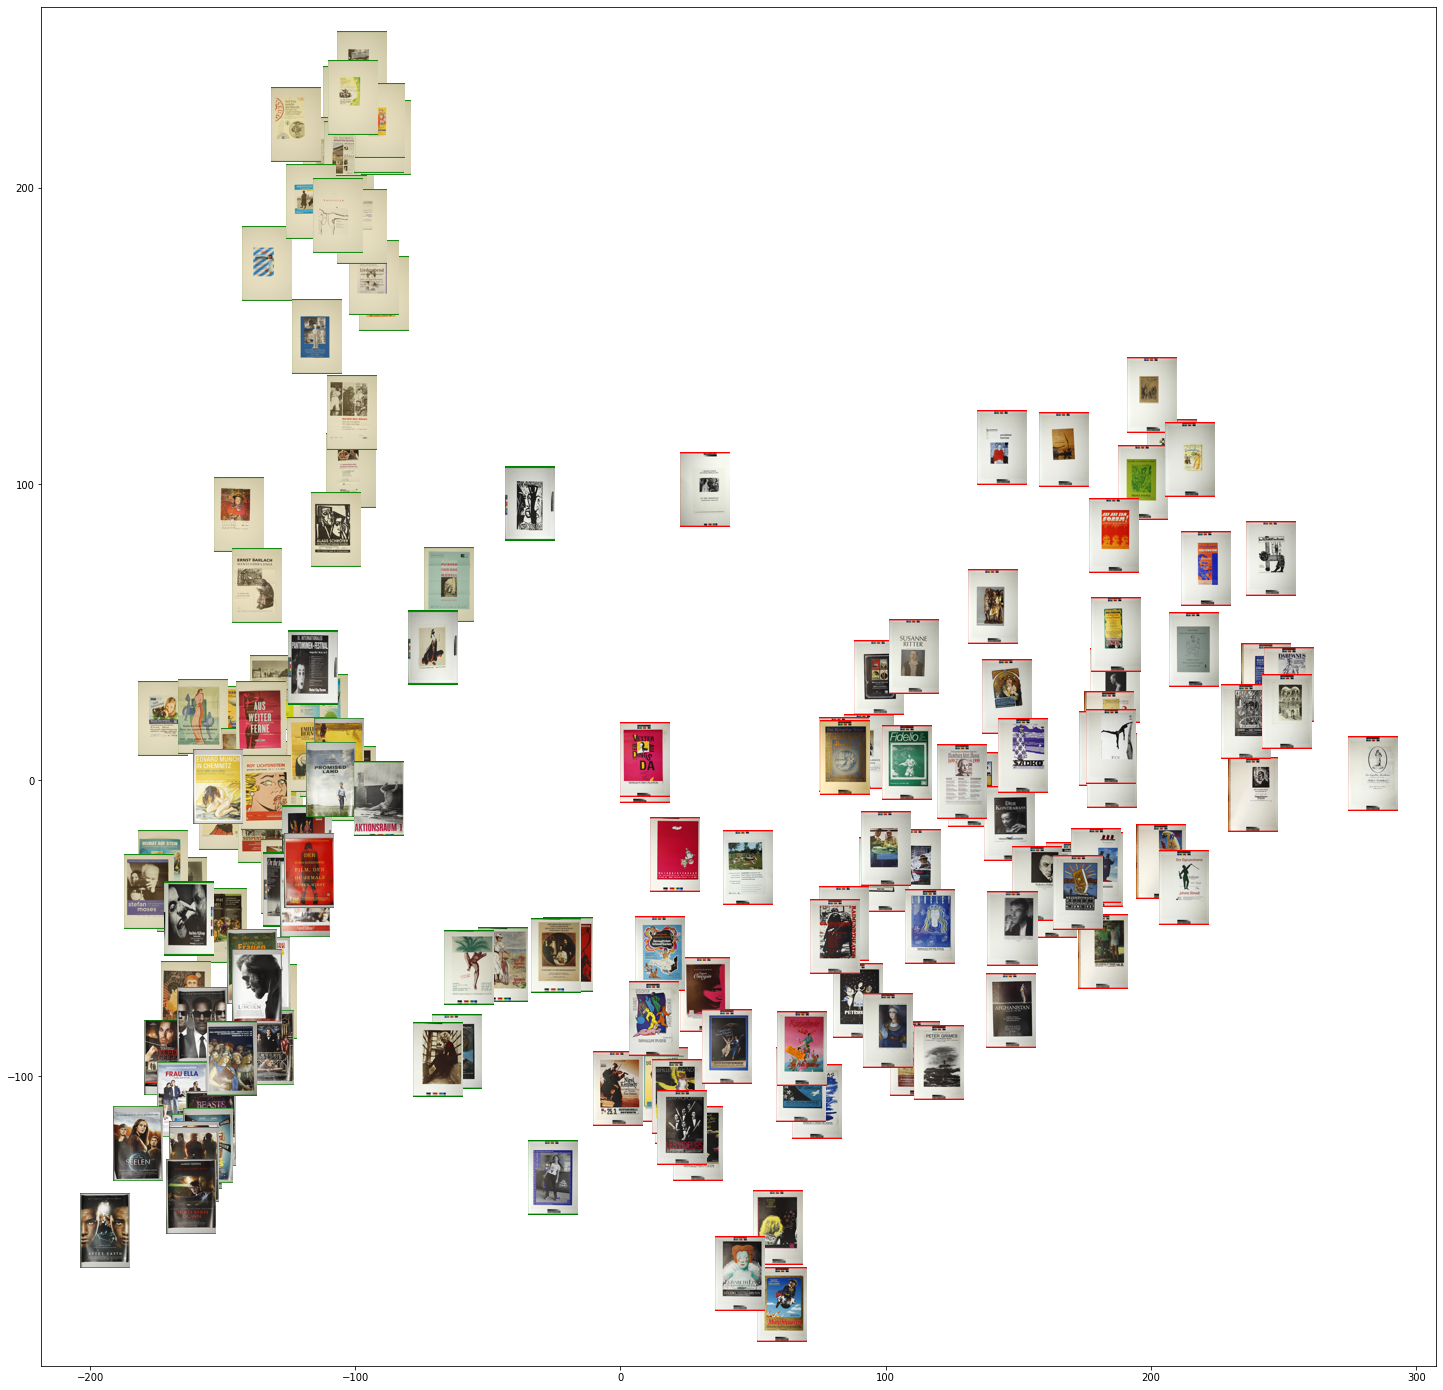

In [11]:
fig = plt.figure(figsize=(25, 25))

for label in range(clusters):
    filtered_label = pca_features[label_list == label]
    
    plt.scatter(filtered_label[:, 0], filtered_label[:, 1])

    for j, name in enumerate(labels_and_names[label]):
        # plt.text(filtered_label0[:, 0][i], filtered_label0[:, 1][i], name)
        image_in_plot(j, name, filtered_label[:, 0][j], filtered_label[:, 1][j], label)

    

# plt.legend()
plt.show()